In [ ]:
# Execution Environment for KLUE-BERT
# pip install tensorflow==2.7.0
# pip install transformers==4.21.0
# TensorFlow version: 2.7.0
# Transformers version: 4.21.0
import tensorflow as tf
import transformers
print(f"TensorFlow version: {tf.__version__}")
print(f"Transformers version: {transformers.__version__}")

            labels
count  4827.000000
mean      0.532422
std       0.706620
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       2.000000
   labels                                          sentences
0       0  Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...
1       0  테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2       2  국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ...
3       1  새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4       1  2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4...
총 샘플의수 : 4827
미싱 데이터 : 0
중복 데이터 : Empty DataFrame
Columns: [labels, sentences]
Index: []
총 샘플의수(중복제거 후) : 4827


<AxesSubplot:>

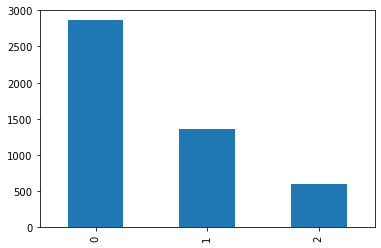

In [1]:
import pandas as pd

# 고객문의 요약 데이터셋 : labels,sentences
dataset = pd.read_csv("dataset_for_cs_summary_classification.csv") # UTF-8 encoding
print(dataset.describe())
print(dataset.head())

# 중복 데이터 확인 및 중복 데이터 제거
print("총 샘플의수 :", len(dataset))
print("미싱 데이터 :", dataset['labels'].isnull().sum()) # 미싱 검사
print("중복 데이터 :", dataset[dataset['sentences'].duplicated()]) # 중복 검사
dataset.drop_duplicates(subset = ['sentences'], inplace = True) # 중복 제거

print("총 샘플의수(중복제거 후) :", len(dataset))
dataset['labels'].value_counts().plot(kind = 'bar')

In [2]:
from sklearn.model_selection import train_test_split

# 데이터셋 분리 : 학습용 및 검증용
dataset_sentences = dataset['sentences'].tolist()
dataset_labels = dataset['labels'].tolist()

TEST_SIZE = 0.1 # 10% of the dataset
RANDOM_STATE = 1234
train_x, test_x, train_y, test_y = train_test_split(dataset_sentences, dataset_labels, 
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE, 
                                                    stratify = dataset_labels)
print(f"학습용 입력 데이터 개수: {len(train_x)}")
print(f"검증용 입력 데이터 개수: {len(test_x)}")

학습용 입력 데이터 개수: 4344
검증용 입력 데이터 개수: 483


In [5]:
import tensorflow as tf
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("klue/bert-base")
tokenized_train_x = tokenizer(train_x, truncation=True, padding=True)
tokenized_test_x = tokenizer(test_x, truncation=True, padding=True)

dataset_for_train = tf.data.Dataset.from_tensor_slices((
    dict(tokenized_train_x),
    train_y
))
print(dataset_for_train)

dataset_for_test = tf.data.Dataset.from_tensor_slices((
    dict(tokenized_test_x),
    test_y
))
print(dataset_for_test)

<TensorSliceDataset shapes: ({input_ids: (120,), token_type_ids: (120,), attention_mask: (120,)}, ()), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>
<TensorSliceDataset shapes: ({input_ids: (84,), token_type_ids: (84,), attention_mask: (84,)}, ()), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>


In [14]:
# 모델 학습

from transformers import TFBertForSequenceClassification

batch_size = 16 # 약 2GB 메모리사용
epochs = 1

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=3, from_pt=True)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

history = model.fit(dataset_for_train.shuffle(2000).batch(8),
                    validation_data=dataset_for_test.shuffle(2000).batch(8),
                    batch_size=batch_size, epochs=epochs, verbose=1)

model.evaluate(dataset_for_test.batch(1024))

# 모델 저장

model.save_pretrained("output/finetuned-klue-bert-for-cs-summary-classification")
tokenizer.save_pretrained("output/finetuned-klue-bert-for-cs-summary-classification")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1/1 [==============================] - 77s 77s/step - loss: 1.0986 - accuracy: 0.1366


[1.098612666130066, 0.13664595782756805]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


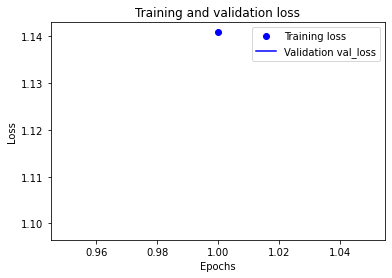

In [16]:
import matplotlib.pyplot as plt

print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# bo = 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss')
# b = 파란색 실선
plt.plot(epochs, val_loss, 'b', label='Validation val_loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [1]:
# 모델 로드 및 테스트

import numpy as np
from transformers import BertTokenizerFast
from transformers import TFBertForSequenceClassification
from transformers import TextClassificationPipeline
from timeit import default_timer

loaded_tokenizer = BertTokenizerFast.from_pretrained("output/finetuned-klue-bert-for-cs-summary-classification")
loaded_model = TFBertForSequenceClassification.from_pretrained("output/finetuned-klue-bert-for-cs-summary-classification")

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework="tf",
    return_all_scores=True
)

start = default_timer()

predicted_result = text_classifier("서비스 나빠요.")
print(predicted_result)

# Get the predicted label name
label_map = {0: "Neutral", 1: "Positive", 2: "Negative"}

predicted_label_scores = []
for prediction_item in predicted_result:
    for prediction_dict in prediction_item:
        predicted_label_scores.append(prediction_dict["score"])
    predicted_label_id = np.argmax(predicted_label_scores)
    predicted_label_name = label_map[predicted_label_id]

print(predicted_label_name)

end = default_timer()
print("Time duration(in seconds):", end - start)

Some layers from the model checkpoint at output/finetuned-klue-bert-for-cs-summary-classification were not used when initializing TFBertForSequenceClassification: ['dropout_189']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at output/finetuned-klue-bert-for-cs-summary-classification.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further traini

[[{'label': 'LABEL_0', 'score': 0.38505589962005615}, {'label': 'LABEL_1', 'score': 0.1275479644536972}, {'label': 'LABEL_2', 'score': 0.48739612102508545}]]
Negative
Time duration(in seconds): 0.2265831000000027


In [1]:
# Print the current date and time in the format:
# "YYYY-MM-DD HH:MM:SS.microseconds"
import datetime
datetime_string = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
print("Current date and time: ", datetime_string)

Current date and time:  2023-03-14 08:18:24.731730
